In [62]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import rotate
from matplotlib.lines import Line2D

### Define functions to create each kinematic class of galaxies

In [9]:
def cookie_cutter(input_array, size):
    
    """
    Cuts an octagon sized shape in square input data by setting all corner values to 0
    """
    
    # Create NxN array to model cuts on
    square = np.ones([size, size])

    # Calculate diagonal to cut based off input array size
    diag_cut = int(0.6*size)
    
    # Use np.tril to cut top right corner
    cut_1 = np.tril(square, k=diag_cut)

    # Use np.triu to cut bottom left corner
    cut_2 = np.triu(cut_1, k=-diag_cut)

    # Flip array to cover all corners
    cut_flip = np.flip(cut_2, 0)

    # Combine arrays and set corners to 0
    octagon = cut_2 + cut_flip - 1

    # Multiply input array by octagon shape
    data_octagon = input_array * octagon
    
    return data_octagon

def rotation_dominated(N):
    """
    Returns an NxN array of a rotation-dominated galaxy with a clear velocity gradient
    """
    # Create rotation-dominated galaxy of a size NxN array using random numbers
    rot_dom = np.zeros([N, N])

    # For a given row of the galaxy, draw from a selected random distribution
    for i in range(N):
        for j in range(N):
            if 0 <= i < int(0.2*N):
                rot_dom[i, j] = np.random.uniform(1, 0.66)
            if int(0.2*N) <= i < int(0.4*N):
                rot_dom[i, j] = np.random.uniform(0.66, 0.33)
            if int(0.4*N) <= i < int(0.6*N):
                rot_dom[i, j] = np.random.uniform(0.33, -0.33)
            if int(0.6*N) <= i < int(0.8*N):
                rot_dom[i, j] = np.random.uniform(-0.33, -0.66)
            if int(0.8*N) <= i < N:
                rot_dom[i, j] = np.random.uniform(-0.66, -1)

    # Add in octagon code:
    rot_dom_final = cookie_cutter(input_array=rot_dom, size=N)
    
    return rot_dom_final

def dispersion_dominated(N):
    """
    Returns an NxN array of a dispersion-dominated galaxy with a random distribution
    """
    # Create dispersion-dominated galaxy array
    dis_dom = np.zeros([N, N])

    # For a given section of the galaxy, drawn from a selected random distribution
    for i in range(N):
        for j in range(N):
            
            # Constrict values within central half radius of galaxy to be smaller
            r_centre = np.sqrt((i - N/2)**2 + (j - N/2)**2)
            if r_centre < N/4:
                dis_dom[i, j] = np.random.uniform(-0.25, 0.25)
            
            # Let every other value have wider range of values
            else:
                dis_dom[i, j] = np.random.uniform(-1, 1)
    
    # Add in octagon code:
    dis_dom_final = cookie_cutter(input_array=dis_dom, size=N)
        
    return dis_dom_final

def calculate_delta_v_star_g(stellar_vel, gas_vel):
    """
    
    Calculates the absolute difference in the stellar and gas velocity at each point in a maps as follows:
    
    |Δ_v-g| = |stellar_vel(x, y) - gas_vel(x, y)|
    
    Also calculates the sum of the residual map at each point to give a value to quantify the offset 
    between the gas and stellar velocity
    
    INPUT
    stellar_vel: stellar velocity map values
    gas_vel: gas velocity map values
    
    OUTPUT
    dvsg_map: absolute map of difference between stellar and gas velocity
    dvsg_sum: sum of dvsg at each point on the dvsg map
    dvsg_N_non_zero: the number of points in the dvsg array that are non-zero
    """
    
    # Create residual map
    dvsg_map = np.abs(stellar_vel - gas_vel)
    
    # Calculate summed residual value
    dvsg_sum = np.sum(dvsg_map)
    
    # Find number of non-zero spaxels
    dvsg_non_zero = np.nonzero(dvsg_map)
    dvsg_N_non_zero = np.shape(dvsg_non_zero)[1]
    
    return dvsg_map, dvsg_sum, dvsg_N_non_zero

### Experiment with making a triangular cut out of arrays

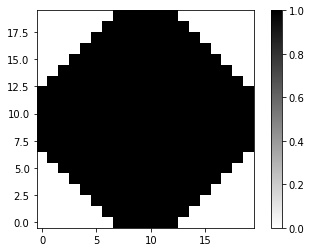

In [7]:
test = np.ones([20, 20])
test_cut = cookie_cutter(input_array=test, size=20)

test_cut

num_xy = np.shape(test_cut)[0]
x = np.arange(num_xy)
y = x

fig, ax = plt.subplots(1)

test_pcolormesh = ax.pcolormesh(x, y, test_cut, cmap=cm.binary, shading="auto")
fig.colorbar(test_pcolormesh)
ax.set_aspect('equal')

### Create DVSG for rotation-dominated stellar velocity and dispersion-dominated gas velocity

dvsg_N_non_zero:  288


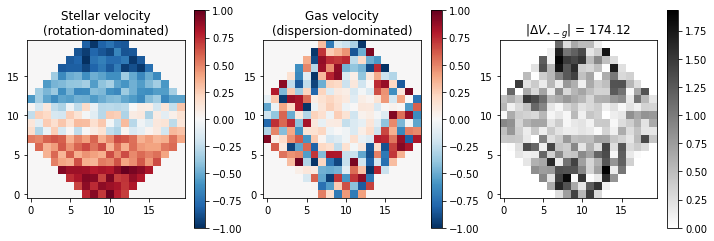

In [10]:
# Create figure (& extra plotting code)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Create variables for each random generation
sv = rotation_dominated(N=20)
gv = dispersion_dominated(N=20)
dvsg = calculate_delta_v_star_g(sv, gv)

# Find number of non-zero spaxels
print("dvsg_N_non_zero: ", dvsg[2])

# Create plotting axes
x = np.arange(np.shape(sv)[0])
y = x

# Plot rotation-dominated stellar velocity
sv_pcolormesh = ax[0].pcolormesh(x, y, sv, cmap="RdBu_r", vmin=-1, vmax=1, shading="auto")
fig.colorbar(sv_pcolormesh, ax=ax[0])
ax[0].set_aspect('equal')
ax[0].set_title("Stellar velocity\n(rotation-dominated)")

# Plot dispersion-dominated-galaxy
gv_pcolormesh = ax[1].pcolormesh(x, y, gv, cmap="RdBu_r", vmin=-1, vmax=1, shading="auto")
fig.colorbar(gv_pcolormesh, ax=ax[1])
ax[1].set_aspect('equal')
ax[1].set_title("Gas velocity\n(dispersion-dominated)")

# Plot dvsg map
dvsg_pcolormesh = ax[2].pcolormesh(x, y, dvsg[0], cmap=cm.binary, shading="auto")
fig.colorbar(dvsg_pcolormesh, ax=ax[2])
ax[2].set_aspect('equal')
ax[2].set_title(r"$|\Delta V_{\star-g}|$ = " + "{:.2f}".format(dvsg[1]));

### Use scipy.ndimage.rotate to change rotation angle of galaxy

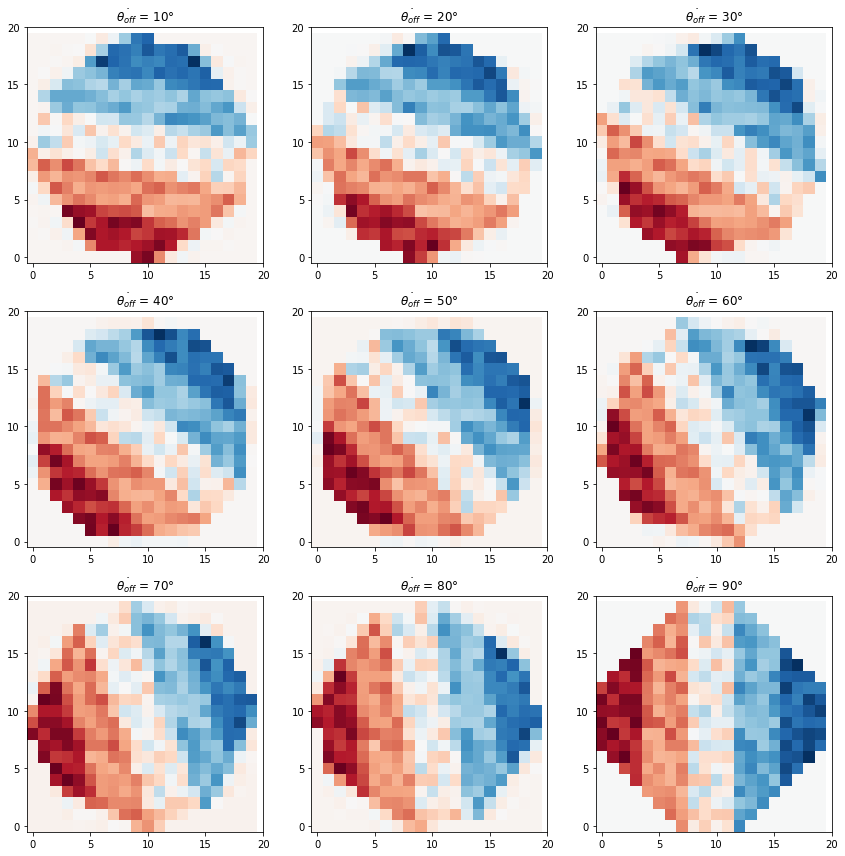

In [11]:
# Create figure (& extra plotting code)
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

sv = rotation_dominated(N=20)

num_xy = np.shape(sv)[0]
x = np.arange(num_xy)
y = x

for i in range(9):
    # Use scipy.ndimage.rotate to incrementally offset stellar velocity by 10 degrees
    sv_off = rotate(input=sv, angle=10*(i+1), reshape=False)  # Don't change shape of array

    # Determine coloumn and row of each subplot
    col = int(np.floor(i/3))
    row = np.remainder(i, 3)
    
    # Plot result
    ax[col, row].pcolormesh(x, y, sv_off, cmap="RdBu_r", shading="auto")
    ax[col, row].set_aspect('equal')
    ax[col, row].set_title(r"$\dot{\theta_{off}}$ = " + str(10*(i+1)) + "$\degree$")
    ax[col, row].set_xticks(ticks=np.linspace(0, np.max(x)+1, 5))
    ax[col, row].set_yticks(ticks=np.linspace(0, np.max(y)+1, 5))

plt.tight_layout()
plt.savefig("rotated_galaxy.jpg")

### Investigate DVSG for each combination of stellar & gas kinematics and different offset angles

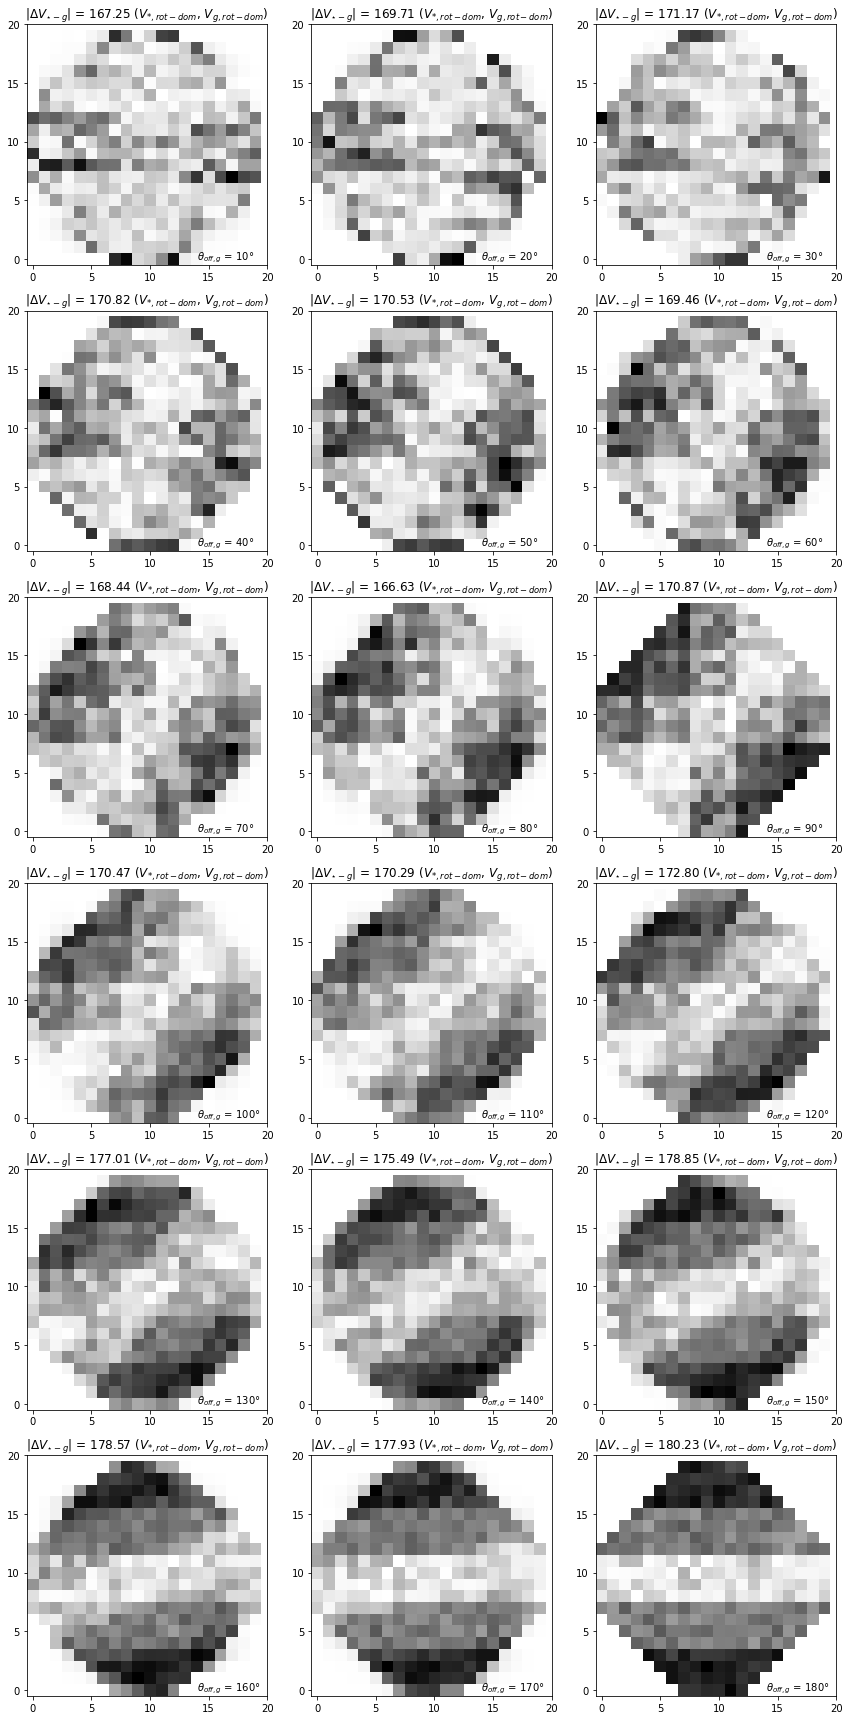

In [51]:
# Create initial velocity maps
sv_rot = rotation_dominated(N=20)
sv_dis = dispersion_dominated(N=20)
gv_rot = rotation_dominated(N=20)
gv_dis = dispersion_dominated(N=20)

# Array to store every residual velocity value between 0 and 180 degrees
dvsg_rot_rot_arr = np.zeros(18)
dvsg_dis_rot_arr = np.zeros(18)
dvsg_rot_dis_arr = np.zeros(18)
dvsg_dis_dis_arr = np.zeros(18)
angle_arr = np.arange(10, 190, 10)

# Create figure (& extra plotting code)
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(12, 24))

num_xy = np.shape(sv_rot)[0]
x = np.arange(num_xy)
y = x

# Rotate between 0 and 180
for i in range(18):
    # Use scipy.ndimage.rotate by 10 degrees each time
    gv_rot_off = rotate(input=gv_rot, angle=angle_arr[i], reshape=False)
    gv_dis_off = rotate(input=gv_dis, angle=angle_arr[i], reshape=False)
    
    # Calculate dvsg for rotation-/dispersion-dominated stellar velocities and rotation dominated gas velocity
    dvsg_rot_rot = calculate_delta_v_star_g(sv_rot, gv_rot_off)
    dvsg_dis_rot = calculate_delta_v_star_g(sv_dis, gv_rot_off)
    
    # Calculate dvsg for rotation-/dispersion-dominated stellar velocities and dispersion dominated gas velocity
    dvsg_rot_dis = calculate_delta_v_star_g(sv_rot, gv_dis_off)
    dvsg_dis_dis = calculate_delta_v_star_g(sv_dis, gv_dis_off)
    
    # Add dvsg for each kinematic conbination and current angle to array
    dvsg_dis_rot_arr[i] = dvsg_dis_rot[1]
    dvsg_dis_dis_arr[i] = dvsg_dis_dis[1]
    dvsg_rot_rot_arr[i] = dvsg_rot_rot[1]
    dvsg_rot_dis_arr[i] = dvsg_rot_dis[1]
    
    # Determine coloumn and row of each subplot
    col = int(np.floor(i/3))
    row = np.remainder(i, 3)
    
    # Only plot rotation-dominated stellar and rotation-dominated gas
    ax[col, row].pcolormesh(x, y, dvsg_rot_rot[0], cmap=cm.binary, shading="auto")
    ax[col, row].set_aspect('equal')
    ax[col, row].set_title("$|\Delta V_{\star-g}|$ = " + "{:.2f}".format(dvsg_dis_rot[1]) + " ($V_{*, rot-dom}$, $V_{g, rot-dom}$)")
    ax[col, row].set_xticks(ticks=np.linspace(0, np.max(x)+1, 5))
    ax[col, row].set_yticks(ticks=np.linspace(0, np.max(y)+1, 5))
    ax[col, row].text(14, 0, r"$\theta_{off, g}$ = " + str(angle_arr[i]) + "$\degree$", fontsize=10)
    
plt.tight_layout()

Plot all kinematic combinations plots together

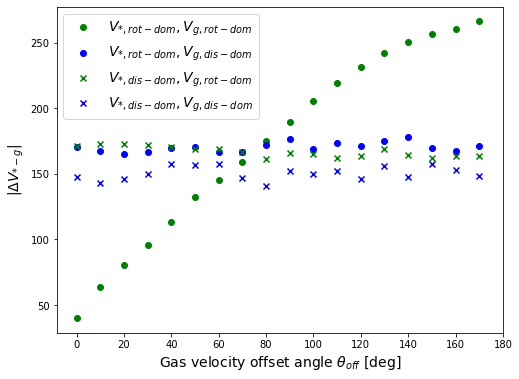

In [14]:
# Rotation-dominated stellar velocity
plt.figure(1, figsize=(8, 6))
plt.scatter(angle_array, dvsg_rot_rot_array, color="green", label="$V_{*, rot-dom}, V_{g, rot-dom}$")
plt.scatter(angle_array, dvsg_rot_dis_array, color="blue", label="$V_{*, rot-dom}, V_{g, dis-dom}$")

# Dispersion-dominated stellar velocity
plt.scatter(angle_array, dvsg_dis_rot_array, color="green", marker="x", label="$V_{*, dis-dom}, V_{g, rot-dom}$")
plt.scatter(angle_array, dvsg_dis_dis_array, color="blue", marker="x", label="$V_{*, dis-dom}, V_{g, dis-dom}$")

plt.xticks(np.arange(0, 200, 20));
plt.xlabel(r"Gas velocity offset angle $\theta_{off}$ [deg]", fontsize=14)
plt.ylabel("$|\Delta V_{* - g}|$", fontsize=14)
plt.legend(fontsize=14)

plt.savefig("DVSG_vs_rotation_angle_with_both_sv_and_gv_kinematic_classes.jpg")

### Investigate whether DVSG scales with number of non-zero spaxels

Initially perform for each kinematic combination but a fixed offset angle

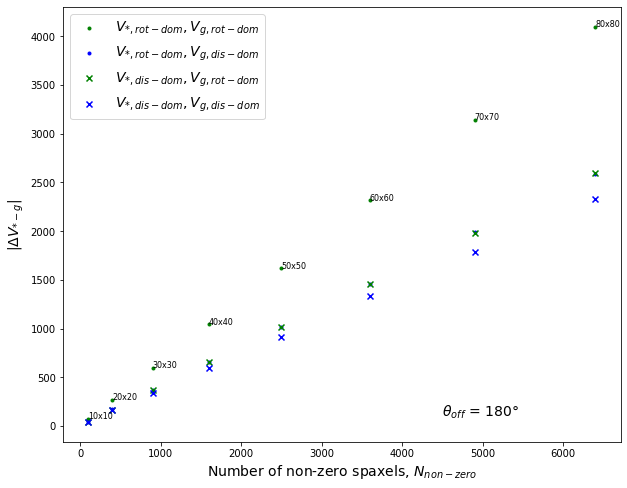

In [47]:
# Define offset angle
theta_off = 180

# Set up list of spaxel dimensions
spx_dim_list = [10, 20, 30, 40, 50, 60, 70, 80]

# Initialise arrays to store
dvsg_at_spx_rot_rot_mean_arr = np.zeros(len(spx_dim_list))
dvsg_at_spx_rot_dis_mean_arr = np.zeros(len(spx_dim_list))
dvsg_at_spx_dis_rot_mean_arr = np.zeros(len(spx_dim_list))
dvsg_at_spx_dis_dis_mean_arr = np.zeros(len(spx_dim_list))
dvsg_N_non_zero_arr = np.zeros(len(spx_dim_list))

# Loop over each spaxel dimension length
for i in range(len(spx_dim_list)):
    
    # Initialise arrays to contain the value of DVSG sum for each iteration at each dimension length
    dvsg_rot_rot_arr = np.zeros(10)
    dvsg_rot_dis_arr = np.zeros(10)
    dvsg_dis_rot_arr = np.zeros(10)
    dvsg_dis_dis_arr = np.zeros(10)
    
    # Iterate over each spaxel size 10 times
    for j in range(10):

        # Initialise stellar and gas velocities
        sv_rot = rotation_dominated(N=spx_dim_list[i])
        sv_dis = dispersion_dominated(N=spx_dim_list[i])
        gv_rot = rotation_dominated(N=spx_dim_list[i])
        gv_dis = dispersion_dominated(N=spx_dim_list[i])

        # Rotate gas velocities relative to stellar velocity at fixed angle (30 degrees)
        gv_rot_off = rotate(input=gv_rot, angle=theta_off, reshape=False)
        gv_dis_off = rotate(input=gv_dis, angle=theta_off, reshape=False)

        # Calculate DVSG for each case
        dvsg_rot_rot = calculate_delta_v_star_g(sv_rot, gv_rot_off)
        dvsg_rot_dis = calculate_delta_v_star_g(sv_rot, gv_dis_off)
        dvsg_dis_rot = calculate_delta_v_star_g(sv_dis, gv_rot_off)
        dvsg_dis_dis = calculate_delta_v_star_g(sv_dis, gv_dis_off)
        
        # Obtain N_non_zero and add to array
        dvsg_N_non_zero = dvsg_rot_rot[2]
        dvsg_N_non_zero_arr[i] = dvsg_N_non_zero
                               
        # Add DVSG sums to arrays
        dvsg_rot_rot_arr[j] = dvsg_rot_rot[1]
        dvsg_rot_dis_arr[j] = dvsg_rot_dis[1]
        dvsg_dis_rot_arr[j] = dvsg_dis_rot[1]
        dvsg_dis_dis_arr[j] = dvsg_dis_dis[1]
    
    # Calculate mean value of DVSG sum
    dvsg_rot_rot_mean = np.mean(dvsg_rot_rot_arr)
    dvsg_rot_dis_mean = np.mean(dvsg_rot_dis_arr)
    dvsg_dis_rot_mean = np.mean(dvsg_dis_rot_arr)
    dvsg_dis_dis_mean = np.mean(dvsg_dis_dis_arr)
                               
    # Add mean values of DVSG sum to arrays
    dvsg_at_spx_rot_rot_mean_arr[i] = dvsg_rot_rot_mean
    dvsg_at_spx_rot_dis_mean_arr[i] = dvsg_rot_dis_mean
    dvsg_at_spx_dis_rot_mean_arr[i] = dvsg_dis_rot_mean
    dvsg_at_spx_dis_dis_mean_arr[i] = dvsg_dis_dis_mean

# Create figure
plt.figure(1, figsize=(10, 8))

# Plot scatter plots
plt.scatter(dvsg_N_non_zero_arr, dvsg_at_spx_rot_rot_mean_arr, label="$V_{*, rot-dom}, V_{g, rot-dom}$", color="green", marker='.')
plt.scatter(dvsg_N_non_zero_arr, dvsg_at_spx_rot_dis_mean_arr, label="$V_{*, rot-dom}, V_{g, dis-dom}$", color="blue", marker='.')
plt.scatter(dvsg_N_non_zero_arr, dvsg_at_spx_dis_rot_mean_arr, label="$V_{*, dis-dom}, V_{g, rot-dom}$", color="green", marker='x')
plt.scatter(dvsg_N_non_zero_arr, dvsg_at_spx_dis_dis_mean_arr, label="$V_{*, dis-dom}, V_{g, dis-dom}$", color="blue", marker='x')

# Labelling/annotation
plt.xlabel("Number of non-zero spaxels, $N_{non-zero}$", fontsize=14)
plt.ylabel("$|\Delta V_{* - g}|$", fontsize=14)
for i in range(0, len(spx_dim_list)):
    plt.annotate(str(spx_dim_list[i]) + "x" + str(spx_dim_list[i]), (dvsg_N_non_zero_arr[i], dvsg_at_spx_rot_rot_mean_arr[i]), fontsize=8)
plt.annotate(r"$\theta_{off}$ = " + str(theta_off) + "$\degree$", (4500, 100), fontsize=14)
plt.legend(fontsize=14)

plt.savefig("DVSG_vs_spx_dim_for_theta=" + str(theta_off) + ".jpg")

### Plot DVSG for all regimes with different sized spaxels

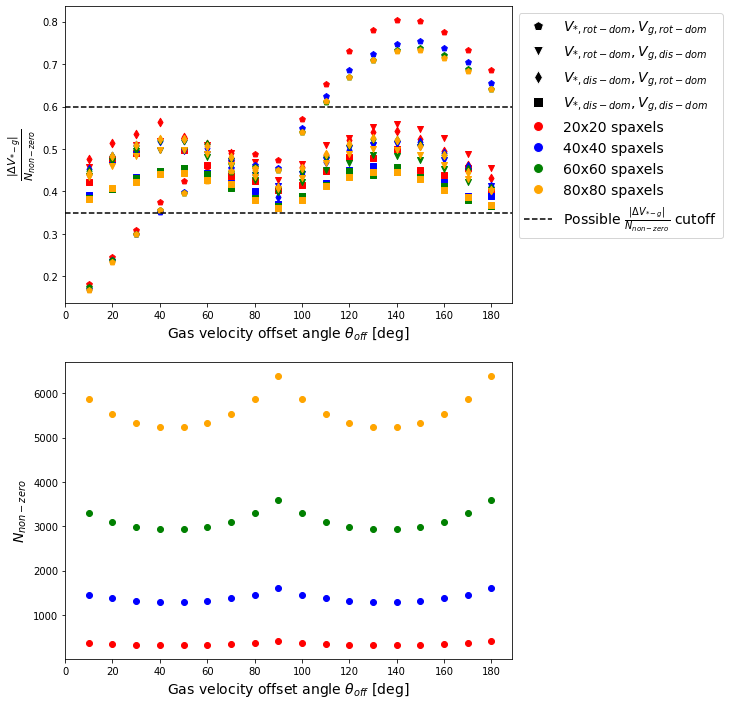

In [115]:
# Set up list of spaxel dimension lengths
spx_dim_list = [20, 40, 60, 80]

# Initialise array of angles
angle_arr = np.arange(10, 190, 10)

# Create figure
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# List of colours for plotting
color_list = ['red', 'blue', 'green', 'orange']

# Loop over each spaxel dimension length
for i in range(len(spx_dim_list)):
    
    # Initialise stellar and gas velocities
    sv_rot = rotation_dominated(N=spx_dim_list[i])
    sv_dis = dispersion_dominated(N=spx_dim_list[i])
    gv_rot = rotation_dominated(N=spx_dim_list[i])
    gv_dis = dispersion_dominated(N=spx_dim_list[i])
    
    # Initialise arrays to store DVSG for each offset at a given spaxel dimension length
    dvsg_at_spx_rot_rot_arr = np.zeros(np.size(angle_arr))
    dvsg_at_spx_rot_dis_arr = np.zeros(np.size(angle_arr))
    dvsg_at_spx_dis_rot_arr = np.zeros(np.size(angle_arr))
    dvsg_at_spx_dis_dis_arr = np.zeros(np.size(angle_arr))
    
    # Loop over each angle
    for j in range(np.size(angle_arr)):
    
        # Rotate gas velocities relative to stellar velocity at fixed angle (30 degrees)
        gv_rot_off = rotate(input=gv_rot, angle=angle_arr[j], reshape=False)
        gv_dis_off = rotate(input=gv_dis, angle=angle_arr[j], reshape=False)

        # Calculate DVSG for each angular offset
        dvsg_rot_rot = calculate_delta_v_star_g(sv_rot, gv_rot_off)
        dvsg_rot_dis = calculate_delta_v_star_g(sv_rot, gv_dis_off)
        dvsg_dis_rot = calculate_delta_v_star_g(sv_dis, gv_rot_off)
        dvsg_dis_dis = calculate_delta_v_star_g(sv_dis, gv_dis_off)

        # Obtain N_non_zero
        dvsg_N_non_zero = dvsg_rot_rot[2]

        # Add DVSG sums WEIGHTED BY N_NON_ZERO to arrays
        dvsg_at_spx_rot_rot_arr[j] = dvsg_rot_rot[1] / dvsg_N_non_zero
        dvsg_at_spx_rot_dis_arr[j] = dvsg_rot_dis[1] / dvsg_N_non_zero
        dvsg_at_spx_dis_rot_arr[j] = dvsg_dis_rot[1] / dvsg_N_non_zero
        dvsg_at_spx_dis_dis_arr[j] = dvsg_dis_dis[1] / dvsg_N_non_zero
        
        # Plot number of non-zero points against offset angle
        ax[1].scatter(angle_arr[j], dvsg_N_non_zero, color=color_list[i])
        
    # Plot DVSG against offset angle without legend
    ax[0].scatter(angle_arr, dvsg_at_spx_rot_rot_arr, color=color_list[i], marker='p')
    ax[0].scatter(angle_arr, dvsg_at_spx_rot_dis_arr, color=color_list[i], marker='v')
    ax[0].scatter(angle_arr, dvsg_at_spx_dis_rot_arr, color=color_list[i], marker='d')
    ax[0].scatter(angle_arr, dvsg_at_spx_dis_dis_arr, color=color_list[i], marker='s')

# Create custom legend
legend_elements = [
    # Marker corresponds to kinematic regime
    Line2D([0], [0], marker='p', color='w', label='$V_{*, rot-dom}, V_{g, rot-dom}$', markerfacecolor='k', markersize=10),
    Line2D([0], [0], marker='v', color='w', label='$V_{*, rot-dom}, V_{g, dis-dom}$', markerfacecolor='k', markersize=10),
    Line2D([0], [0], marker='d', color='w', label='$V_{*, dis-dom}, V_{g, rot-dom}$', markerfacecolor='k', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='$V_{*, dis-dom}, V_{g, dis-dom}$', markerfacecolor='k', markersize=10),
    
    # Color corresponds to spaxel dimension length
    Line2D([0], [0], marker='o', color='w', label='20x20 spaxels', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='40x40 spaxels', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='60x60 spaxels', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='80x80 spaxels', markerfacecolor='orange', markersize=10),
    
    # Line corresponds to cutoff
    Line2D([0], [0], color="k", linestyle="--", label="Possible $\\frac{|\\Delta V_{* - g}|}{N_{non-zero}}$ cutoff")
]


# Add legends to plot
ax[0].legend(handles=legend_elements, fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Extra plotting code
ax[0].set_xticks(np.arange(0, 200, 20));
ax[0].set_xlabel(r"Gas velocity offset angle $\theta_{off}$ [deg]", fontsize=14)
ax[0].set_ylabel(r"$\frac{|\Delta V_{* - g}|}{N_{non-zero}}$", fontsize=16);
ax[0].axhline(y=0.35, color="k", linestyle="--")
ax[0].axhline(y=0.6, color="k", linestyle="--")

ax[1].set_xticks(np.arange(0, 200, 20));
ax[1].set_xlabel(r"Gas velocity offset angle $\theta_{off}$ [deg]", fontsize=14)
ax[1].set_ylabel("$N_{non-zero}$", fontsize=14);

The results show that $\Delta V_{*-g}$ weighted by $N_{non-zero}$ can provide constraints for when a galaxy is in the kinematic regime of a rotation-dominated stellar velocity and rotation-dominated gas velocity. Generally:

$$
\left\{
\begin{array}{ll}
V_{*, \text{rot-dom}}, V_{g, \text{rot-dom}} & \text{If } 0 \leq \frac{\Delta V_{*-g}}{N_{non-zero}} \lesssim 0.35 \text{ or } 0.6 \lesssim \frac{\Delta V_{*-g}}{N_{non-zero}} \leq 1 \\
V_{*, \text{rot-dom}}, V_{g, \text{dis-dom}} & \\
V_{*, \text{dis-dom}}, V_{g, \text{rot-dom}} & \text{Otherwise} \\
V_{*, \text{dis-dom}}, V_{g, \text{dis-dom}} &
\end{array}
\right.
$$

The periodic behaviour of periodic variation of $N_{non-zero}$ with $\theta_{off}$ is the cause for the variation in $\frac{\Delta V_{*-g}}{N_{non-zero}}$ with $\theta_{off}$. This seems to be an artifact of the rotation of the original image by  ```scipy.ndimage.rotate``` and is therefore unlikely to occur in real galaxies with an offset.